<a href="https://colab.research.google.com/github/webmostafij/DDProject/blob/main/17182103086.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.autograd import grad

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

if 'higher' not in sys.modules:
  !pip install higher
import higher as higher

print(sys.version)
print(torch.__version__)

3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
1.10.0+cu111


In [ ]:
# Set random seeds
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# Set important parameters
learning_rate = 1e-2
inner_loop_iterations = 32
outer_loop_iterations = 5
num_classes = 10

noise_size = 64     # size of noise or curriculum vector
img_size = 28    # width / height of generated image

inner_loop_batch_size = 128
outer_loop_batch_size = 128

mnist_mean = 0.1307         # for normalizing mnist images
mnist_std = 0.3081          # for normalizing mnist images

imgs_per_row = num_classes

Dataset

In [ ]:
# Initialize MNIST transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x)),
    transforms.ToTensor(),
    transforms.Normalize((mnist_mean,), (mnist_std,)),
])

# Create data splits
train = datasets.MNIST('./data', train=True, transform=transform, download=True)
train, val = torch.utils.data.random_split(train, [50000, 10000])
test = datasets.MNIST('./data', train=False, transform=transform, download=True)
print('Created train, val, and test datasets.')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Created train, val, and test datasets.


Dataloader

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train, batch_size=outer_loop_batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    val, batch_size=outer_loop_batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    test, batch_size=outer_loop_batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True,
)

Generator 

In [ ]:
class Teacher(nn.Module):
    '''
    Implements a Teacher module.
    '''
    def __init__(self):
        super().__init__()

        conv1_filters = 64
        fc1_size = 1024
        
        self.fc2_filters = 128
        self.fc2_width = img_size
        fc2_size = self.fc2_filters * self.fc2_width * self.fc2_width

        self.fc1 = nn.Linear(noise_size + num_classes, fc1_size)
        nn.init.kaiming_normal_(self.fc1.weight, 0.1)
        self.bn_fc1 = nn.BatchNorm1d(fc1_size, momentum=0.1)

        self.fc2 = nn.Linear(fc1_size, fc2_size)
        nn.init.kaiming_normal_(self.fc2.weight, 0.1)
        self.bn_fc2 = nn.BatchNorm2d(self.fc2_filters, momentum=0.1)

        self.conv1 = nn.Conv2d(self.fc2_filters, conv1_filters, 3, 1, padding=3 // 2)
        self.bn_conv1 = nn.BatchNorm2d(conv1_filters, momentum=0.1)

        self.conv2 = nn.Conv2d(conv1_filters, 1, 3, 1, padding=3 // 2)
        self.bn_conv2 = nn.BatchNorm2d(1, momentum=0.1)
        
        self.tanh = nn.Tanh()

        self.learner_optim_params = nn.Parameter(torch.tensor([0.02, 0.5]), True)

    def forward(self, x, target):
        '''
        Synthesizes a batch of training examples for the learner.
        Args:
            x (torch.tensor): shape (b, 64)
            target (torch.tensor): shape (b, 10)
        '''
        # Fully connected block 1
        x = torch.cat([x, target], dim=1)   # shape (b, 64+10)
        x = self.fc1(x)                     # shape (b, 1024)
        x = F.leaky_relu(x, 0.1)
        x = self.bn_fc1(x)

        # Fully connected block 2
        x = self.fc2(x)                     # shape (b, 128*28*28)
        x = F.leaky_relu(x, 0.1)
        x = x.view(                         # shape (b, 128, 28, 28)
            -1, self.fc2_filters, self.fc2_width, self.fc2_width
        )
        x = self.bn_fc2(x)

        # Convolutional block 1
        x = self.conv1(x)                   # shape (b, 64, 28, 28)
        x = self.bn_conv1(x)
        x = F.leaky_relu(x, 0.1)

        # Convolutional block 2
        x = self.conv2(x)                   # shape (b, 1, 28,  28)
        x = self.bn_conv2(x)

        x = (self.tanh(x) + 1 - 2 * mnist_mean) / (2 * mnist_std)
        return x, target 

Classifier

In [ ]:
class Learner(nn.Module):
    '''
    Implements a Learner module.
    '''
    def __init__(self, num_conv1=None, num_conv2=None):
        super().__init__()

        # Randomly select and evaluate convolutional depth
        # for evaluation/comparison in neural architecture search
        if num_conv1 is None:
            conv1_filters = np.random.randint(32, 64)
        else:
            conv1_filters = num_conv1
        if num_conv2 is None:
            conv2_filters = np.random.randint(64, 128)
        else:
            conv2_filters = num_conv2

        self.conv1 = nn.Conv2d(1, conv1_filters, 3, 1)
        self.bn1 = nn.BatchNorm2d(conv1_filters, momentum=0.1)

        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, 3, 1)
        self.bn2 = nn.BatchNorm2d(conv2_filters, momentum=0.1)

        c1_size = (img_size - 3 + 1) // 2
        c2_size = (c1_size - 3 + 1) // 2
        
        self.fc = nn.Linear(conv2_filters * c2_size * c2_size, num_classes)
        self.bn3 = nn.BatchNorm1d(num_classes, momentum=0.1)
        
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.activation(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.bn3(x)

        return x

Training

In [ ]:
def generate_img(img_tensor):
    '''
    Function that renders an MNIST image.
    '''
    return torchvision.transforms.ToPILImage()(1 - ((img_tensor * mnist_std) + mnist_mean))

In [ ]:
teacher = Teacher()
params_to_train = list(teacher.parameters())

# If we want to use a curriculum, we initialize the learnable parameters here
use_curriculum = True
if use_curriculum:
    curriculum = nn.Parameter(torch.randn(inner_loop_iterations, inner_loop_batch_size, noise_size), requires_grad=True)
    params_to_train += [curriculum]

optimizer_teacher = optim.Adam(params_to_train, lr=learning_rate)

# For each inner loop iterations, we use the same sequence of labels. 
# This allows the curriculum vectors to train to stable labels 
label = torch.tensor([x % num_classes for x in range(inner_loop_batch_size)])

# For the inner loop loss, we use cross entropy
loss_fn = nn.CrossEntropyLoss()

# Here we initialize iterators on the train and val datasets
train_iterator = iter(train_loader)
val_iterator = iter(val_loader)
test_iterator = iter(test_loader)

------------------ Outer loop iteration 1 ------------------
Examples 0 - 9 from beginning of inner loop:


Examples 0 - 9 from end of inner loop:


Inner loop losses: [2.6703457832336426, 2.645026206970215, 2.681507110595703, 2.6658427715301514, 2.7405998706817627, 2.4710588455200195, 2.5797953605651855, 2.3567452430725098, 2.5401852130889893, 2.3940908908843994, 2.341440200805664, 2.538485050201416, 2.304974317550659, 2.3839070796966553, 2.271450996398926, 2.216782569885254, 2.435528516769409, 2.30399751663208, 2.4448611736297607, 2.259875774383545, 2.336167812347412, 2.211899518966675, 2.2307045459747314, 2.243312120437622, 2.2538580894470215, 2.3382034301757812, 2.258178234100342, 2.2871692180633545, 2.1698904037475586, 2.136939525604248, 2.1530468463897705, 2.1583220958709717]
Train accuracy: 0.09375
Val accuracy: 0.1171875
------------------ Outer loop iteration 2 ------------------
Examples 0 - 9 from beginning of inner loop:


Examples 0 - 9 from end of inner loop:


Inner loop losses: [2.659332036972046, 2.619061231613159, 2.2800517082214355, 2.299887180328369, 2.0207130908966064, 1.9434373378753662, 1.960270643234253, 1.844711422920227, 1.8314337730407715, 1.7637569904327393, 1.6171798706054688, 1.7799441814422607, 1.5913069248199463, 1.757724404335022, 1.53241765499115, 1.494884967803955, 1.5703333616256714, 1.5703120231628418, 1.5169905424118042, 1.4478130340576172, 1.5339161157608032, 1.5064224004745483, 1.5546095371246338, 1.4250539541244507, 1.4113694429397583, 1.4864095449447632, 1.5205215215682983, 1.3452345132827759, 1.5218669176101685, 1.3659616708755493, 1.441867470741272, 1.403502345085144]
Train accuracy: 0.6640625
Val accuracy: 0.6328125
------------------ Outer loop iteration 3 ------------------
Examples 0 - 9 from beginning of inner loop:


Examples 0 - 9 from end of inner loop:


Inner loop losses: [2.9614109992980957, 2.484269142150879, 2.0231122970581055, 1.687349557876587, 1.4614473581314087, 1.4041271209716797, 1.5253727436065674, 1.2050533294677734, 1.2319504022598267, 1.2179409265518188, 1.1702879667282104, 1.2093411684036255, 1.0455632209777832, 1.1168566942214966, 1.107413649559021, 1.044893741607666, 1.0177630186080933, 0.9665524959564209, 0.9657405614852905, 0.9672898054122925, 0.9907450675964355, 1.0640345811843872, 1.029788851737976, 0.9112594723701477, 0.960887610912323, 0.9416018128395081, 0.9590324759483337, 0.8900535106658936, 0.9505808353424072, 0.921637773513794, 0.8849027156829834, 0.976815402507782]
Train accuracy: 0.7109375
Val accuracy: 0.7265625
------------------ Outer loop iteration 4 ------------------
Examples 0 - 9 from beginning of inner loop:


Examples 0 - 9 from end of inner loop:


Inner loop losses: [2.7102575302124023, 2.243273973464966, 1.743721842765808, 1.4567919969558716, 1.2692376375198364, 1.2471519708633423, 1.2628213167190552, 1.112573266029358, 1.0837020874023438, 1.0172970294952393, 1.0657315254211426, 1.0586762428283691, 0.9715369939804077, 0.9917954206466675, 0.9907445311546326, 0.951570451259613, 0.9465124607086182, 0.8755204081535339, 0.8820890784263611, 0.85659259557724, 0.8587149977684021, 0.9356763958930969, 0.8689390420913696, 0.8060070276260376, 0.825798511505127, 0.8149139881134033, 0.8259177207946777, 0.7899662852287292, 0.8126965165138245, 0.7934446334838867, 0.7446444630622864, 0.8401460647583008]
Train accuracy: 0.828125
Val accuracy: 0.7421875
------------------ Outer loop iteration 5 ------------------
Examples 0 - 9 from beginning of inner loop:


Examples 0 - 9 from end of inner loop:


Inner loop losses: [2.6086177825927734, 1.9791606664657593, 1.6027265787124634, 1.336297631263733, 1.2227009534835815, 1.177804708480835, 1.1749851703643799, 1.0467355251312256, 1.020764708518982, 0.9915964007377625, 1.0040687322616577, 0.9979429841041565, 0.8831200003623962, 0.9023911356925964, 0.9396195411682129, 0.889531672000885, 0.8062232732772827, 0.7864211201667786, 0.7644567489624023, 0.8042334318161011, 0.7943709492683411, 0.8404538035392761, 0.7347185015678406, 0.7026923894882202, 0.7392464876174927, 0.7561657428741455, 0.7394148707389832, 0.6680473685264587, 0.6882641911506653, 0.6501415967941284, 0.6579307913780212, 0.7397246956825256]
Train accuracy: 0.7734375
Val accuracy: 0.8359375
----------------------------------
Done training...
Final test accuracy: 0.8299278846153846


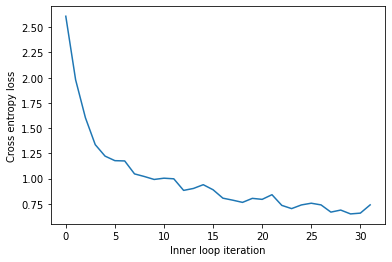

In [ ]:
for it, real_data in enumerate(train_loader):

    teacher.train()
    optimizer_teacher.zero_grad()

    # We also optimize the learner learning rate and momentum with the
    # outer loop updates
    learner_lr = teacher.learner_optim_params[0]
    learner_momentum = teacher.learner_optim_params[1]

    # Here we sample a learner with random number of conv filters
    learner = Learner()
    inner_optim = optim.SGD(learner.parameters(), lr=learner_lr.item(), momentum=learner_momentum.item())
    learner.train()

    inner_losses = []
    with higher.innerloop_ctx(learner, inner_optim, override={'lr': [learner_lr], 'momentum': [learner_momentum]}) as (flearner, diffopt):
        for step in range(inner_loop_iterations):

            # Data generation
            if use_curriculum:
                z_vec = curriculum[step]
            else:
                z_vec = torch.randn(inner_loop_batch_size, noise_size)

            one_hot = F.one_hot(label, num_classes)
    
            # Pass input to teacher to generate synthetic images
            teacher_output, teacher_target = teacher(z_vec, one_hot)

            # ====== Show intermediate generated images ======
            if step == 0:
                print('------------------ Outer loop iteration', it + 1, '------------------')
                print('Examples 0 - 9 from beginning of inner loop:')
                background = Image.new('L', (img_size * imgs_per_row + imgs_per_row + 1, img_size + 2))
                for i in range(imgs_per_row): # indexes column 
                    background.paste(generate_img(teacher_output[i]), (i * 28 + i + 1, 1))
                display(background)

            if step == (inner_loop_iterations - 1):
                print('Examples 0 - 9 from end of inner loop:')
                background = Image.new('L', (img_size * imgs_per_row + imgs_per_row + 1, img_size + 2))
                for i in range(imgs_per_row): # indexes column
                    background.paste(generate_img(teacher_output[i]), (i * 28 + i + 1, 1))
                display(background)

            # Pass teacher output to the learner 
            learner_output = flearner(teacher_output)
            loss = loss_fn(learner_output, label)
            diffopt.step(loss)

            inner_losses.append(loss.item())

        correct = 0
        data, target = real_data
        output = flearner(data)
        loss = loss_fn(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy_train = correct / target.shape[0]

        print("Inner loop losses:", inner_losses)
        print("Train accuracy:", accuracy_train)

        # Compute accuracy on validation set
        data, target = next(val_iterator)
        print
        output = flearner(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / outer_loop_batch_size
        print("Val accuracy:", accuracy)

        if (it == outer_loop_iterations - 1):
            # Compute accuracy on test set
            correct = 0
            for i, (data, target) in enumerate(test_loader):
                output = flearner(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / (outer_loop_batch_size * len(test_loader))
            print("----------------------------------")
            print("Done training...")
            print("Final test accuracy:", accuracy)

            # Final inner loop training curve
            plt.plot(np.arange(len(inner_losses)), inner_losses)
            plt.xlabel("Inner loop iteration")
            plt.ylabel("Cross entropy loss")
            plt.show()

            break

        loss.backward()

    optimizer_teacher.step()

Simple MNIST NAS

In [ ]:
num_architectures = 10

best_accuracy = 0

for i in range(num_architectures):

    # Randomly sample architecture
    conv1_filters = np.random.randint(1, 64)
    conv2_filters = np.random.randint(1, 128)

    learner = Learner(conv1_filters, conv2_filters)
    inner_optim = optim.SGD(learner.parameters(), lr=learner_lr.item(), momentum=learner_momentum.item())
    learner.train()

    # For some reason if we don't use higher here, accuracy drops significantly
    with higher.innerloop_ctx(learner, inner_optim, override={'lr': [learner_lr], 'momentum': [learner_momentum]}) as (flearner, diffopt):
        for step in range(inner_loop_iterations):

            # Data generation
            if use_curriculum:
                z_vec = curriculum[step]
            else:
                z_vec = torch.randn(inner_loop_batch_size, noise_size)

            one_hot = F.one_hot(label, num_classes)

            # Pass input to teacher to generate synthetic images
            teacher_output, teacher_target = teacher(z_vec, one_hot)

            # Pass teacher output to the learner
            learner_output = flearner(teacher_output)
            loss = loss_fn(learner_output, label)
            diffopt.step(loss)

        # Compute accuracy on validation set
        correct = 0
        for val_idx, (data, target) in enumerate(val_loader, 0):
            #if (val_idx == val_iterations): break
            output = flearner(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / (outer_loop_batch_size * len(val_loader))

        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            filter_counts = (conv1_filters, conv2_filters)

        print("------------------------- Architecture", i + 1," -------------------------")
        print("Num conv1 filters:", conv1_filters, ", Num conv2 filters:", conv2_filters, ", Val accuracy:", accuracy)

        
        if (i == num_architectures - 1):
            correct = 0
            for test_idx, (data, target) in enumerate(test_loader, 0):
                #if (test_idx == test_iterations): break
                output = flearner(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / (outer_loop_batch_size * len(test_loader))
            print("------------------------- Best architecture -------------------------")
            print("Num conv1 filters:", filter_counts[0], ", Num conv2 filters:", filter_counts[1], ", Test accuracy:", accuracy)
          

------------------------- Architecture 1  -------------------------
Num conv1 filters: 22 , Num conv2 filters: 115 , Val accuracy: 0.8161057692307693
------------------------- Architecture 2  -------------------------
Num conv1 filters: 37 , Num conv2 filters: 88 , Val accuracy: 0.8191105769230769
------------------------- Architecture 3  -------------------------
Num conv1 filters: 7 , Num conv2 filters: 89 , Val accuracy: 0.8269230769230769
------------------------- Architecture 4  -------------------------
Num conv1 filters: 25 , Num conv2 filters: 13 , Val accuracy: 0.7533052884615384
------------------------- Architecture 5  -------------------------
Num conv1 filters: 59 , Num conv2 filters: 66 , Val accuracy: 0.8175080128205128
------------------------- Architecture 6  -------------------------
Num conv1 filters: 39 , Num conv2 filters: 40 , Val accuracy: 0.8046875
------------------------- Architecture 7  -------------------------
Num conv1 filters: 24 , Num conv2 filters: 47 ,

Visualization 

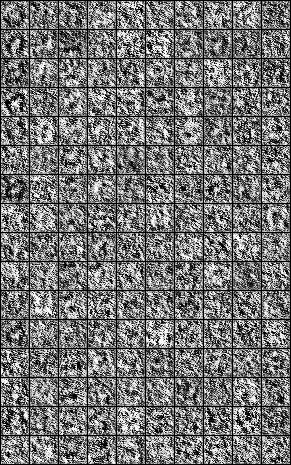

In [ ]:
imgs_per_row = num_classes
rows = inner_loop_iterations // 2 * img_size + inner_loop_iterations // 2 + 1
cols = imgs_per_row * img_size + imgs_per_row + 1
background = Image.new('L', (cols, rows))

for step in range(0, inner_loop_iterations, 2): # indexes row
    if use_curriculum:
        z_vec = curriculum[step]
    else:
        z_vec = torch.randn(inner_loop_batch_size, noise_size)

    one_hot = F.one_hot(label, num_classes)

    teacher_output, teacher_target = teacher(z_vec, one_hot)

    for i in range(imgs_per_row): # indexes column 
        background.paste(generate_img(teacher_output[i]), (i * img_size + i + 1, (step // 2) * img_size + (step // 2) + 1))

display(background)